We first install the libraries we are going to use

In [ ]:
!pip install numpy pandas scikit-learn tensorflow opencv-python matplotlib


Installation complete.


We download the dataset from kaggle.
We create a blank folder for the Train and Test sets.
We copy the dataset into these folders.
We are doing these copying operation because we are going to process the data later on this project. If we need the original dataset aswell, we can directly use this folder. We do not need to download the whole dataset again.

In [ ]:
import os
import shutil
import kagglehub

# 1. Define the target root directory where the dataset will be linked for the rest of the script
DATA_ROOT = '/content/gtsrb_kaggle'
os.makedirs(DATA_ROOT, exist_ok=True)
print(f"Data will be downloaded and linked from: {DATA_ROOT}")

# 2. Download Data using Kagglehub
print("Downloading GTSRB Dataset via Kagglehub...")
try:
    # This downloads the full dataset and returns the local path where the files are stored
    # Dataset source: meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    download_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

    print(f"Dataset downloaded to: {download_path}")

    # 3. Reorganize the structure: copy Train, Test, and Test.csv into the clean DATA_ROOT

    # The actual data is directly under the download_path
    actual_data_source_path = download_path

    # Copy Train folder
    train_source = os.path.join(actual_data_source_path, 'Train')
    train_dest = os.path.join(DATA_ROOT, 'Train')
    if os.path.exists(train_source):
        shutil.copytree(train_source, train_dest, dirs_exist_ok=True)
    else:
        print(f"Warning: 'Train' directory not found at {train_source}")

    # Copy Test folder
    test_source = os.path.join(actual_data_source_path, 'Test')
    test_dest = os.path.join(DATA_ROOT, 'Test')
    if os.path.exists(test_source):
        shutil.copytree(test_source, test_dest, dirs_exist_ok=True)
    else:
        print(f"Warning: 'Test' directory not found at {test_source}")

    # Copy Test.csv
    csv_source = os.path.join(actual_data_source_path, 'Test.csv')
    csv_dest = os.path.join(DATA_ROOT, 'Test.csv')
    if os.path.exists(csv_source):
        shutil.copy(csv_source, csv_dest)
    else:
        print(f"Warning: 'Test.csv' not found at {csv_source}")

    print(f"File structure reorganized into: {DATA_ROOT}")

except Exception as e:
    print(f"Error during Kagglehub download or linking. Please check if you have authenticated to Kaggle and the dataset exists: {e}")

print("Dataset setup complete. Please run the next cell.")


Data will be downloaded and linked from: /content/gtsrb_kaggle
Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Dataset downloaded to: /kaggle/input/gtsrb-german-traffic-sign
File structure reorganized into: /content/gtsrb_kaggle
Dataset setup complete. Please run the next cell.


# Data Preprocessing Setup

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import kagglehub

# --- Global Configurations ---
DATA_ROOT_PATH = DATA_ROOT
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
NUM_CLASSES = 43 # Based on the GTSRB dataset having 43 classes

# --- Data Loading Functions ---
def load_train_data(root_path):
    """
    Loads data from the 'Train' folder where subfolders are class IDs (0, 1, 2...).
    Resizes images to IMG_WIDTH, IMG_HEIGHT.
    """
    images = []
    labels = []
    train_path = os.path.join(root_path, 'Train')
    print(f"Loading Training data from: {train_path}")

    for class_id in range(NUM_CLASSES):
        class_dir = os.path.join(train_path, str(class_id))
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            try:
                img_path = os.path.join(class_dir, img_name)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                    images.append(image)
                    labels.append(class_id)
            except Exception as e:
                pass
    return np.array(images), np.array(labels)

def load_test_data(root_path):
    """
    Loads data using 'Test.csv' to map images in 'Test' folder to labels.
    Resizes images to IMG_WIDTH, IMG_HEIGHT.
    """
    images = []
    labels = []
    csv_path = os.path.join(root_path, 'Test.csv')
    print(f"Loading Test data using: {csv_path}")

    try:
        df = pd.read_csv(csv_path)
        for index, row in df.iterrows():
            img_rel_path = row['Path']
            img_path = os.path.join(root_path, img_rel_path)
            try:
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                    images.append(image)
                    labels.append(row['ClassId'])
            except Exception as e:
                pass
    except Exception as e:
        print(f"Error reading Test.csv: {e}")

    return np.array(images), np.array(labels)

# --- Image Dimension Retrieval Function (for original sizes, not resized) ---
def get_image_dimensions(root_path, dataset_type='Train'):
    """Loads image dimensions without resizing for distribution analysis."""
    widths = []
    heights = []

    if dataset_type == 'Train':
        data_path = os.path.join(root_path, 'Train')
        for class_id in range(NUM_CLASSES): # Use NUM_CLASSES for iteration
            class_dir = os.path.join(data_path, str(class_id))
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            h, w, _ = img.shape
                            widths.append(w)
                            heights.append(h)
                    except Exception as e:
                        pass
    elif dataset_type == 'Test':
        csv_path = os.path.join(root_path, 'Test.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            for index, row in df.iterrows():
                # The 'Path' column in Test.csv already contains the relative path like 'Test/00000.png'
                img_rel_path = row['Path']
                img_path = os.path.join(root_path, img_rel_path)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        h, w, _ = img.shape
                        widths.append(w)
                        heights.append(h)
                except Exception as e:
                    pass
    return widths, heights

print("Data Exploration Setup Complete.")


Data Exploration Setup Complete.


# Data Exploration and Imbalance Analysis

Reloading full training data...
Loading Training data from: /content/gtsrb_kaggle/Train
Reloading test data...
Loading Test data using: /content/gtsrb_kaggle/Test.csv


/tmp/ipython-input-1760889902.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=class_counts_train.index, y=class_counts_train.values, palette='viridis', width=0.5) # Thinner bars
/tmp/ipython-input-1760889902.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=class_counts_test.index, y=class_counts_test.values, palette='viridis', width=0.5) # Thinner bars


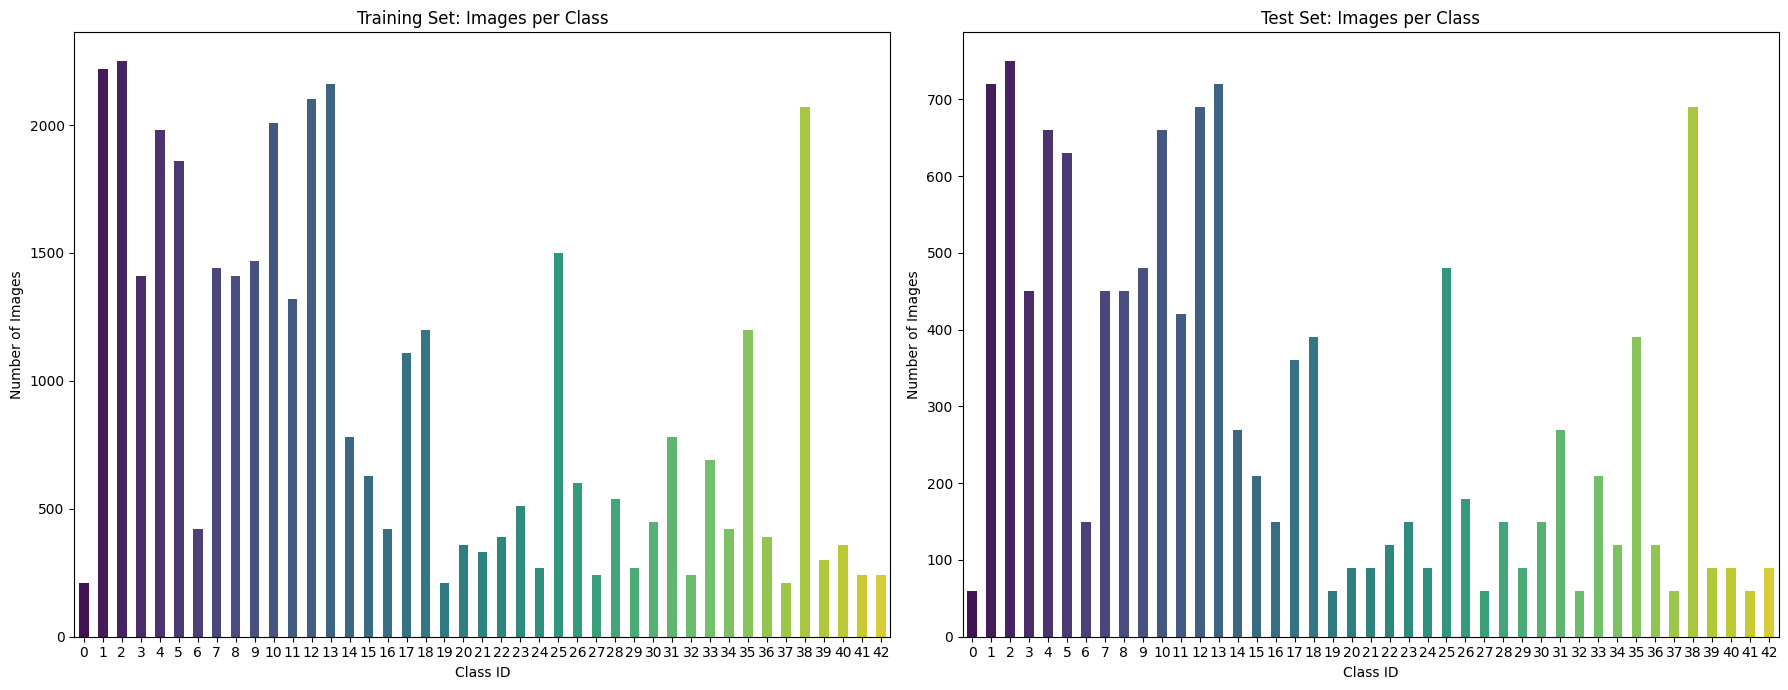

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Total images in each class for train and test set

if 'X_train_full' not in locals() or 'y_train_full' not in locals():
    print("Reloading full training data...")
    X_train_full, y_train_full = load_train_data(DATA_ROOT_PATH)

if 'X_test' not in locals() or 'y_test' not in locals():
    print("Reloading test data...")
    X_test, y_test = load_test_data(DATA_ROOT_PATH)


plt.figure(figsize=(18, 7)) # Increased figure width for better label readability

plt.subplot(1, 2, 1)
class_counts_train = pd.Series(y_train_full).value_counts().sort_index()
ax1 = sns.barplot(x=class_counts_train.index, y=class_counts_train.values, palette='viridis', width=0.5) # Thinner bars
plt.title('Training Set: Images per Class')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
class_counts_test = pd.Series(y_test).value_counts().sort_index()
ax2 = sns.barplot(x=class_counts_test.index, y=class_counts_test.values, palette='viridis', width=0.5) # Thinner bars
plt.title('Test Set: Images per Class')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')


plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd
import kagglehub

# 2. Total number of different subclasses in ShapeID and ColorID

try:
    download_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
except Exception as e:
    print(f"Could not retrieve download_path: {e}. Assuming default Kaggle path.")
    # Fallback to the typical Kaggle mounted path if download fails
    download_path = '/kaggle/input/gtsrb-german-traffic-sign'

# --- Robust search for SignNames.csv ---
def find_sign_names_csv(base_path, data_root):
    potential_paths = [
        os.path.join(base_path, 'SignNames.csv'),
        os.path.join(base_path, 'Meta', 'SignNames.csv'),
        # Often Kaggle downloads extract into a subfolder named after the dataset
        os.path.join(base_path, 'gtsrb-german-traffic-sign', 'SignNames.csv'),
        # Check if it might have been copied to DATA_ROOT as well
        os.path.join(data_root, 'SignNames.csv')
    ]
    for path in potential_paths:
        if os.path.exists(path):
            return path
    return None

sign_names_csv_path = find_sign_names_csv(download_path, DATA_ROOT) # Pass DATA_ROOT here

if sign_names_csv_path:
    sign_names_df = pd.read_csv(sign_names_csv_path)

    print(f"Total unique ShapeIDs: {sign_names_df['ShapeID'].nunique()}")
    print(f"Unique ShapeIDs: {sign_names_df['ShapeID'].unique()}")
    print(f"Total unique ColorIDs: {sign_names_df['ColorID'].nunique()}")
    print(f"Unique ColorIDs: {sign_names_df['ColorID'].unique()}")
else:
    print(f"Warning: SignNames.csv not found in any expected locations under {download_path} or {DATA_ROOT}")


Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.


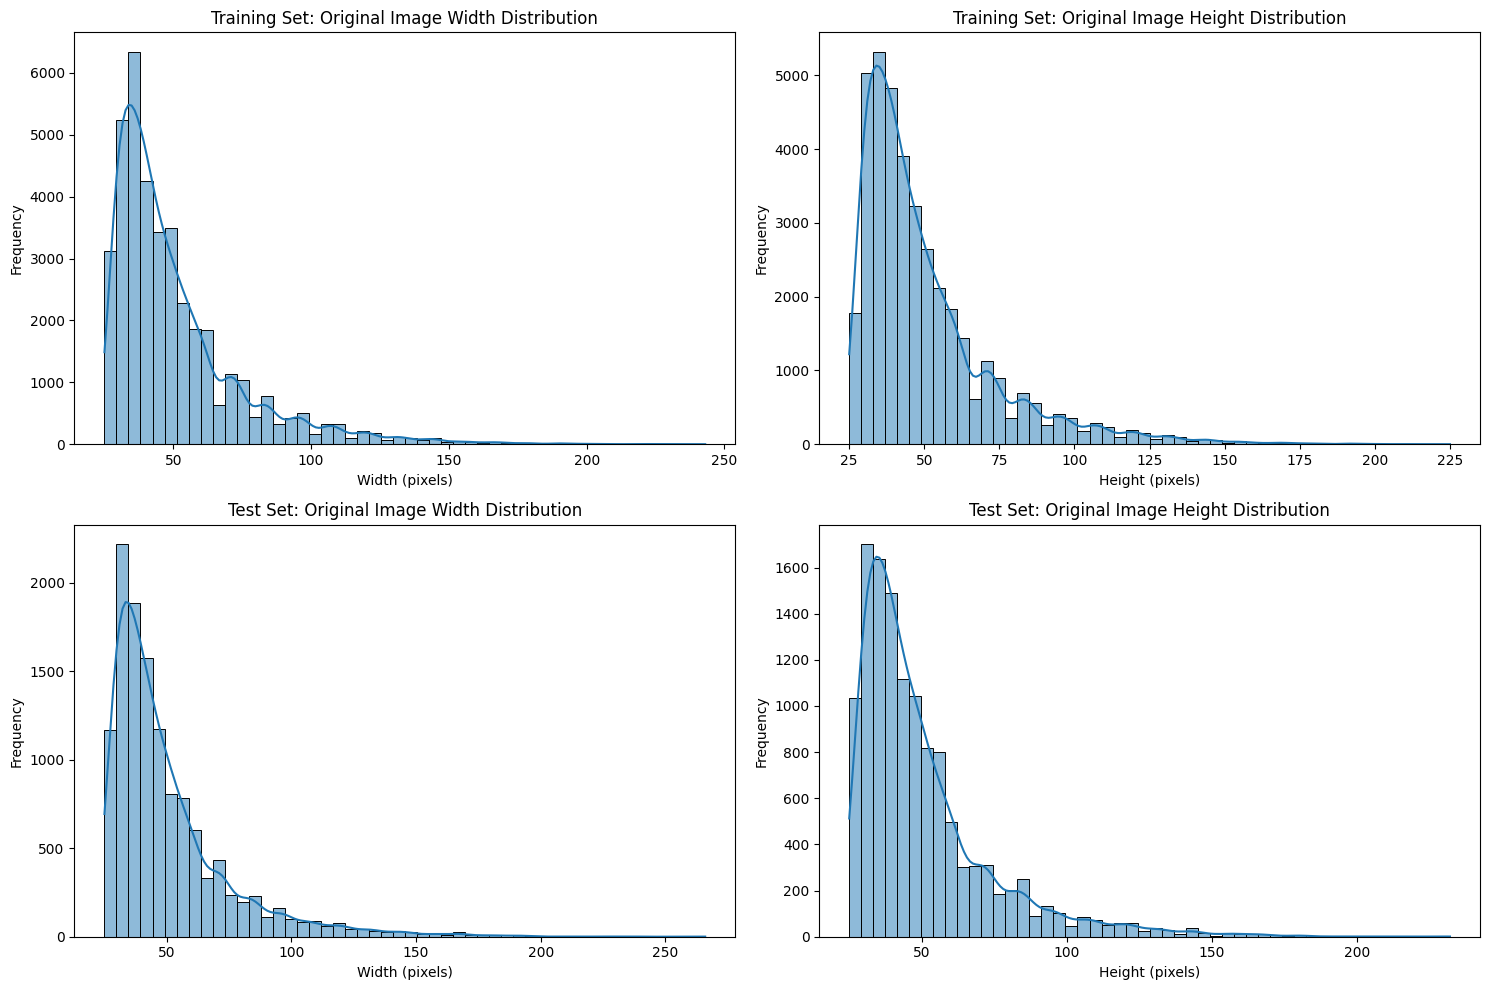

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 3. Width and height distribution for train and test set (original images)

def get_image_dimensions(root_path, dataset_type='Train'):
    """Loads image dimensions without resizing."""
    widths = []
    heights = []

    if dataset_type == 'Train':
        data_path = os.path.join(root_path, 'Train')
        for class_id in range(NUM_CLASSES):
            class_dir = os.path.join(data_path, str(class_id))
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            h, w, _ = img.shape
                            widths.append(w)
                            heights.append(h)
                    except Exception as e:
                        pass
    elif dataset_type == 'Test':
        csv_path = os.path.join(root_path, 'Test.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            for index, row in df.iterrows():
                img_rel_path = row['Path']
                img_path = os.path.join(root_path, img_rel_path)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        h, w, _ = img.shape
                        widths.append(w)
                        heights.append(h)
                except Exception as e:
                    pass
    return widths, heights

print("Collecting original image dimensions...")
train_widths, train_heights = get_image_dimensions(DATA_ROOT_PATH, 'Train')
test_widths, test_heights = get_image_dimensions(DATA_ROOT_PATH, 'Test')

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(train_widths, bins=50, kde=True)
plt.title('Training Set: Original Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(train_heights, bins=50, kde=True)
plt.title('Training Set: Original Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(test_widths, bins=50, kde=True)
plt.title('Test Set: Original Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(test_heights, bins=50, kde=True)
plt.title('Test Set: Original Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# CONFIG

We configure our Blur function to use later.
We can determine if we want to apply Average or Gaussian Blur, to apply blur to the training, validation and test set or not. We can adjust the intensity of the blur. And also we can change the saving percentage to see the percentage of the blurred images.


In [ ]:
# ==========================================
# CONFIGURATION
# ==========================================
# Root path for the dataset structure (Train/, Test/, Test.csv)
# This now points to the local path where the data was extracted.
DATA_ROOT_PATH = DATA_ROOT
OUTPUT_DIR = '/content/blurred_images_output' # Saving output locally in Colab environment

IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
NUM_CLASSES = 43

# Blur Configuration
BLUR_CONFIG = {
    # Choose 'GAUSSIAN' or 'AVERAGE' (simulates lens blur)
    'blur_type': 'AVERAGE',

    # Choose which sets to apply the blur to
    'apply_to_train': True,
    'apply_to_val': True,
    'apply_to_test': True,

    # Intensity of the blur (0 to 100%)
    'intensity_percent': 20,

    # Save a sample percentage of blurred images to OUTPUT_DIR
    'save_sample_percent': 0.1
}

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory created at: {OUTPUT_DIR}")

Output directory created at: /content/blurred_images_output


We wrote our blur functions. The parameter of both blur types are determined by the blur percentage. Then we load the data from the copied folder and extracted their labels.


In [ ]:
# ==========================================
# 1. BLUR FUNCTIONS
# ==========================================
import cv2
import numpy as np

def apply_gaussian_blur(images, sigma):
    """Applies Gaussian blur using a calculated sigma."""
    blurred_images = []
    for img in images:
        blurred = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)
        blurred_images.append(blurred)
    return np.array(blurred_images)

def apply_average_blur(images, kernel_size):
    """
    Applies Average Blur (simulates lens blur with a square kernel).
    Kernel size must be odd (e.g., 3, 5, 7...).
    """
    blurred_images = []
    for img in images:
        blurred = cv2.blur(img, (kernel_size, kernel_size))
        blurred_images.append(blurred)
    return np.array(blurred_images)

def apply_blur(images, labels, intensity_percent, dataset_name, save_sample_percent, output_root):
    """
    Master function to apply the chosen blur type and handle saving.
    """
    if intensity_percent <= 0:
        return images

    blur_type = BLUR_CONFIG['blur_type'].upper()

    # Map intensity_percent (0-100) to appropriate parameter
    if blur_type == 'GAUSSIAN':
        param = (intensity_percent / 100.0) * 5.0
        print(f"Applying Gaussian Blur to {dataset_name} (Intensity: {intensity_percent}%, Sigma: {param:.2f})...")
        blurred_images = apply_gaussian_blur(images, param)

    elif blur_type == 'AVERAGE':
        # Kernel Size: Maps 0-100% to an odd integer kernel size (e.g., 1 to 9)
        param = int(np.ceil((intensity_percent / 100.0) * 4)) * 2 + 1
        param = max(1, param)
        print(f"Applying Average Blur to {dataset_name} (Intensity: {intensity_percent}%, Kernel Size: {param}x{param})...")
        blurred_images = apply_average_blur(images, param)

    else:
        print(f"Warning: Unknown blur type '{blur_type}'. No blur applied.")
        return images

    # --- Saving setup ---
    num_images_to_save = int(len(images) * save_sample_percent)
    if num_images_to_save > 0:
        save_dir = os.path.join(output_root, f'{dataset_name}_Blur_{blur_type}_{intensity_percent}percent')
        os.makedirs(save_dir, exist_ok=True)
        print(f"Saving {num_images_to_save} sample images to: {save_dir}")

        # Save samples
        for i in range(num_images_to_save):
            # We save the original BGR image data (0-255) before normalization
            filename = f'blurred_sample_{i:05d}_class{labels[i]}.png'
            # Note: CV2 expects BGR format and saves the 0-255 range.
            cv2.imwrite(os.path.join(save_dir, filename), blurred_images[i])

    return blurred_images

# ==========================================
# 2. DATA LOADING
# ==========================================
import pandas as pd

def load_train_data(root_path):
    """
    Loads data from the 'Train' folder where subfolders are class IDs (0, 1, 2...).
    """
    images = []
    labels = []
    train_path = os.path.join(root_path, 'Train')

    print(f"Loading Training data from: {train_path}")

    for class_id in range(NUM_CLASSES):
        class_dir = os.path.join(train_path, str(class_id))

        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            try:
                img_path = os.path.join(class_dir, img_name)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                    images.append(image)
                    labels.append(class_id)
            except Exception as e:
                pass

    return np.array(images), np.array(labels)

def load_test_data(root_path):
    """
    Loads data using 'Test.csv' to map images in 'Test' folder to labels.
    """
    images = []
    labels = []
    csv_path = os.path.join(root_path, 'Test.csv')

    print(f"Loading Test data using: {csv_path}")

    try:
        df = pd.read_csv(csv_path)

        for index, row in df.iterrows():
            img_rel_path = row['Path']
            # The CSV path is relative to the root of the GTSRB dataset, which is now DATA_ROOT_PATH
            img_path = os.path.join(root_path, img_rel_path)

            try:
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
                    images.append(image)
                    labels.append(row['ClassId'])
            except Exception as e:
                pass

    except Exception as e:
        print(f"Error reading Test.csv: {e}")

    return np.array(images), np.array(labels)



We divided train set into Train-Validation set with %80 Train - %20 Validation. We are using validation set only in CNN. And now, the classical ml approaches does not train the validation set. **Thus, we have 20% data loss now. We have to use the original train data in the classic approaches in the upcoming progresses.**

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Load Data
X_train_full, y_train_full = load_train_data(DATA_ROOT_PATH)
X_test, y_test = load_test_data(DATA_ROOT_PATH)

print(f"Loaded Full Training Set: {X_train_full.shape}")
print(f"Loaded Test Set: {X_test.shape}")

# 2. Split 'Train' into 'Train' and 'Validation'
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# 3. Apply Blur (Based on User Config)
if BLUR_CONFIG['apply_to_train']:
    # NOTE: We pass the labels (y_train) to the blur function for file naming
    X_train = apply_blur(X_train, y_train, BLUR_CONFIG['intensity_percent'], 'Train',
                         BLUR_CONFIG['save_sample_percent'], OUTPUT_DIR)

if BLUR_CONFIG['apply_to_val']:
    X_val = apply_blur(X_val, y_val, BLUR_CONFIG['intensity_percent'], 'Validation',
                       BLUR_CONFIG['save_sample_percent'], OUTPUT_DIR)
if BLUR_CONFIG['apply_to_test']:
    X_test = apply_blur(X_test, y_test, BLUR_CONFIG['intensity_percent'], 'Test',
                        BLUR_CONFIG['save_sample_percent'], OUTPUT_DIR)

# 4. Normalize
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"Final Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Loading Training data from: /content/gtsrb_kaggle/Train
Loading Test data using: /content/gtsrb_kaggle/Test.csv
Loaded Full Training Set: (39209, 64, 64, 3)
Loaded Test Set: (12630, 64, 64, 3)
Applying Average Blur to Train (Intensity: 20%, Kernel Size: 3x3)...
Saving 3136 sample images to: /content/blurred_images_output/Train_Blur_AVERAGE_20percent
Applying Average Blur to Validation (Intensity: 20%, Kernel Size: 3x3)...
Saving 784 sample images to: /content/blurred_images_output/Validation_Blur_AVERAGE_20percent
Applying Average Blur to Test (Intensity: 20%, Kernel Size: 3x3)...
Saving 1263 sample images to: /content/blurred_images_output/Test_Blur_AVERAGE_20percent
Final Shapes -> Train: (31367, 64, 64, 3), Val: (7842, 64, 64, 3), Test: (12630, 64, 64, 3)


# CLASSICAL ML APPROACHES AND PCA

Applying the classical ML approaches. Before applying we flatted the 64*64*3 dimension into 12288 numbers.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV # Added this import

print("\n--- Traditional ML Pipeline ---")

# Flatten for non-deep models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# PCA
print("Applying PCA...")
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

def evaluate_model(model, X_t, y_t, name):
    preds = model.predict(X_t)
    acc = accuracy_score(y_t, preds)
    print(f"\n{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_t, preds, zero_division=0))
    return acc



--- Traditional ML Pipeline ---
Applying PCA...


In [ ]:
# KNN
print("Tuning KNN Hyperparameters...")

  # 1. Define the model and the parameters to test
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}


grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro', n_jobs=1)

  # 3. Train (Fit) to find the best k using full training data
grid_knn.fit(X_train_pca, y_train)

  # 4. Get the best model
best_k = grid_knn.best_params_['n_neighbors']
best_knn_model = grid_knn.best_estimator_

print(f"Best k found: {best_k}")

  # 5. Evaluate the optimized model
evaluate_model(best_knn_model, X_test_pca, y_test, f"Tuned KNN (k={best_k})")

# 2. SVM Tuning
print("\nTuning SVM Hyperparameters...")
svm = SVC(kernel='rbf')
param_grid_svm = {'C': [0.1, 1, 10, 100]}

# Using full training data for tuning now
# CHANGED: n_jobs=1 to prevent memory crash, cv=2 for faster execution
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=1) # Changed cv to 2
print(f"Searching for best C using full training data...")
grid_svm.fit(X_train_pca, y_train)

best_C = grid_svm.best_params_['C']
print(f"Best C found: {best_C}")

# Retrain the best SVM model on the full training data
print("Training final SVM model on full training data...")
best_svm_model = SVC(kernel='rbf', C=best_C)
best_svm_model.fit(X_train_pca, y_train) # Changed from y_train_full to y_train

evaluate_model(best_svm_model, X_test_pca, y_test, f"Tuned SVM (C={best_C})")


# ==========================================
# 3. Random Forest Tuning
# ==========================================
print("\nTuning Random Forest Hyperparameters...")
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=1)
grid_rf.fit(X_train_pca, y_train)

best_rf_params = grid_rf.best_params_
best_rf_model = grid_rf.best_estimator_
print(f"Best RF Params: {best_rf_params}")
evaluate_model(best_rf_model, X_test_pca, y_test, "Tuned Random Forest")

Tuning KNN Hyperparameters...
Best k found: 3

Tuned KNN (k=3) Accuracy: 36.41%
              precision    recall  f1-score   support

           0       0.16      0.32      0.21        60
           1       0.31      0.36      0.33       720
           2       0.21      0.24      0.22       750
           3       0.09      0.15      0.11       450
           4       0.21      0.28      0.24       660
           5       0.20      0.31      0.24       630
           6       0.58      0.27      0.37       150
           7       0.11      0.18      0.14       450
           8       0.22      0.26      0.24       450
           9       0.48      0.28      0.35       480
          10       0.54      0.54      0.54       660
          11       0.44      0.34      0.38       420
          12       0.72      0.55      0.62       690
          13       0.86      0.85      0.86       720
          14       0.82      0.39      0.53       270
          15       0.22      0.09      0.13       210
 

0.6030878859857483


 EVALUATING: KNN
Accuracy:  36.18%
F1-Score:  37.37%
Precision: 40.38%
Recall:    36.18%


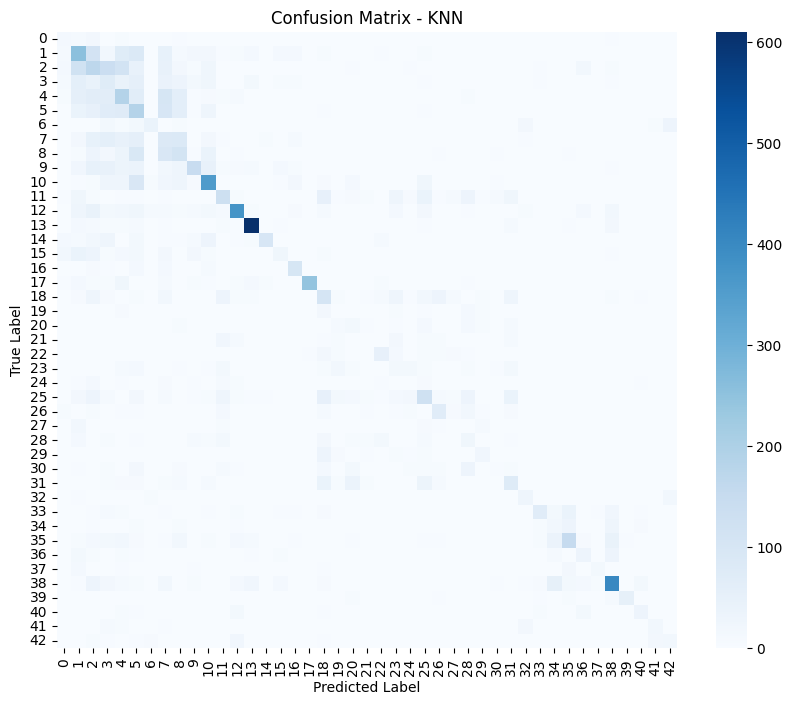


 EVALUATING: SVM
Accuracy:  71.73%
F1-Score:  71.46%
Precision: 72.16%
Recall:    71.73%


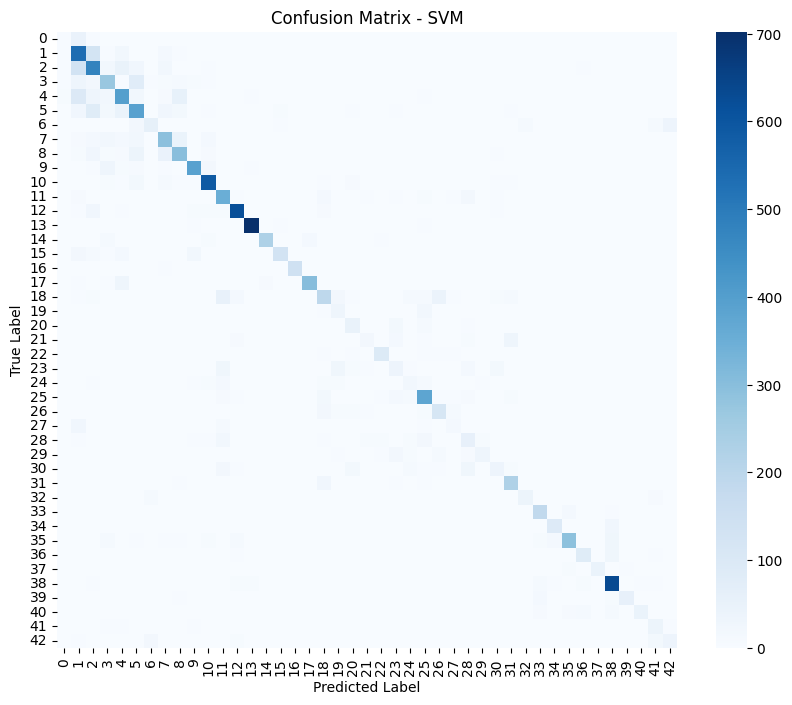


 EVALUATING: Random Forest
Accuracy:  61.01%
F1-Score:  59.94%
Precision: 63.30%
Recall:    61.01%


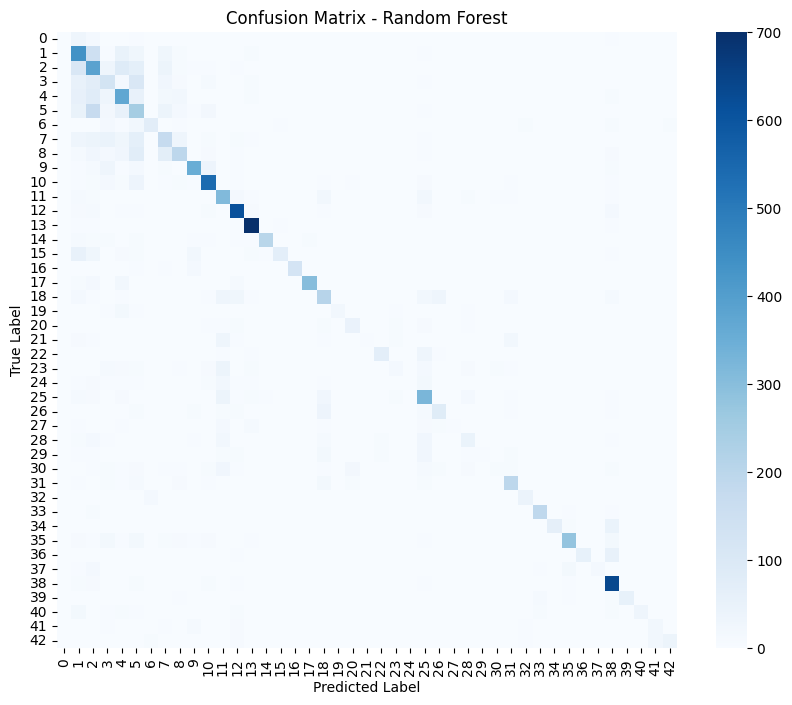

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# --- EVALUATION FUNCTION ---
def print_full_evaluation(model, X_test, y_test, model_name):
    print(f"\n{'='*40}")
    print(f" EVALUATING: {model_name}")
    print(f"{'='*40}")

    # 1. Make Predictions
    y_pred = model.predict(X_test)

    # 2. Calculate Metrics
    # 'weighted': Calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label).
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    # 3. Print Metrics
    print(f"Accuracy:  {acc*100:.2f}%")
    print(f"F1-Score:  {f1*100:.2f}%")
    print(f"Precision: {prec*100:.2f}%")
    print(f"Recall:    {rec*100:.2f}%")

    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# --- RUN EVALUATION FOR ALL MODELS ---

# 1. Evaluate KNN
if 'best_knn_model' in locals():
    print_full_evaluation(best_knn_model, X_test_pca, y_test, "KNN")
else:
    print("KNN model not found. Run the training cell first.")

# 2. Evaluate SVM
if 'best_svm_model' in locals():
    print_full_evaluation(best_svm_model, X_test_pca, y_test, "SVM")
else:
    print("SVM model not found. Run the training cell first.")

# 3. Evaluate Random Forest
if 'best_rf_model' in locals():
    print_full_evaluation(best_rf_model, X_test_pca, y_test, "Random Forest")
else:
    print("Random Forest model not found. Run the training cell first.")

# TRADITIONAL ML MODEL TRAINING WITH THE BEST HPS

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

print("\n--- Applying Classical ML Models with Selected Hyperparameters ---")

# 1. KNN Model (k=3)
print("Training KNN with k=3...")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_pca, y_train)
evaluate_model(knn_model, X_test_pca, y_test, "KNN (k=3)")

# 2. SVM Model (C=100)
print("\nTraining SVM with C=100...")
svm_model = SVC(kernel='rbf', C=100)
svm_model.fit(X_train_pca, y_train)
evaluate_model(svm_model, X_test_pca, y_test, "SVM (C=100)")

# 3. Random Forest Model (max_depth=None, n_estimators=100)
print("\nTraining Random Forest with max_depth=None, n_estimators=100...")
rf_model = RandomForestClassifier(max_depth=None, n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)
evaluate_model(rf_model, X_test_pca, y_test, "Random Forest (max_depth=None, n_estimators=100)")


--- Applying Classical ML Models with Selected Hyperparameters ---
Training KNN with k=3...

KNN (k=3) Accuracy: 32.78%
              precision    recall  f1-score   support

           0       0.14      0.23      0.17        60
           1       0.25      0.29      0.27       720
           2       0.18      0.24      0.21       750
           3       0.10      0.14      0.12       450
           4       0.21      0.28      0.24       660
           5       0.18      0.27      0.22       630
           6       0.48      0.23      0.31       150
           7       0.08      0.13      0.10       450
           8       0.17      0.22      0.19       450
           9       0.38      0.19      0.25       480
          10       0.46      0.47      0.47       660
          11       0.39      0.33      0.36       420
          12       0.70      0.53      0.60       690
          13       0.82      0.81      0.81       720
          14       0.75      0.35      0.48       270
          15  

0.5642913697545526

# DEEP LEARNING MODEL

In [ ]:
import shutil
import os

keras_tuner_dir = 'keras_tuner_dir'

if os.path.exists(keras_tuner_dir):
    shutil.rmtree(keras_tuner_dir)
    print(f"Removed '{keras_tuner_dir}' directory.")
else:
    print(f"'{keras_tuner_dir}' directory does not exist. Nothing to remove.")

'keras_tuner_dir' directory does not exist. Nothing to remove.


# HP SEARCH AND MODEL DEFINITITON

In [ ]:

!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import keras_tuner as kt
import math # Import math for ceil function

print("\n--- Starting Advanced CNN Setup (2 Conv Blocks) ---")

# =======================================================
# A. F1-Score Metric and Class Weight Calculation
# =======================================================

# Define F1-Score Metric for Keras (for the objective and metrics)
def f1_score(y_true, y_pred):
    # For sparse categorical crossentropy, y_true is integer labels. Convert to one-hot for F1-score calculation.
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=NUM_CLASSES)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true_one_hot * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_one_hot, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Calculate BASE Class Weights (Inverse Frequency)

y_train_int = y_train.astype(int)
class_labels = np.unique(y_train_int)
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=class_labels,
    y=y_train_int
)

CLASS_WEIGHTS_DICT = dict(zip(class_labels, class_weights_array))

# =======================================================
# B. Tuner Model Builder Function (2 Conv Blocks)
# =======================================================

def build_tuned_model(hp):
    # --- Class Weight Multiplier Tuning ---
    # Alpha will be applied only to minority classes (weight > 1.0)
    hp_weight_multiplier = hp.Choice('class_weight_multiplier', values=[1.0, 1.5, 2.0])

    tuned_class_weights = CLASS_WEIGHTS_DICT.copy()
    for class_id, weight in tuned_class_weights.items():
        if weight > 1.0:
            tuned_class_weights[class_id] = weight * hp_weight_multiplier

    # --- Architecture Hyperparameters to Search ---
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1,max_value=0.3)
    hp_dropout_2_conv = hp.Float('dropout_2_conv', min_value=0.2,max_value=0.4)
    hp_dropout_3_dense = hp.Float('dropout_3_dense', min_value=0.4, max_value=0.5)

    hp_filters_1 = hp.Choice('filters_1', values=[32, 64])
    hp_filters_2 = hp.Choice('filters_2', values=[64, 128])
    hp_units = hp.Int('units', min_value=128, max_value=512, step=128)
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3)

    # --- Model Definition (Original 2 Blocks) ---
    model = Sequential([
        # First Conv Block
        Conv2D(hp_filters_1, (5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(hp_dropout_1), # TUNED

        # Second Conv Block
        Conv2D(hp_filters_2, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(hp_dropout_2_conv), # TUNED

        Flatten(),

        # Dense Block
        Dense(hp_units, activation='relu'),
        Dropout(hp_dropout_3_dense), # TUNED
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', f1_score] # F1-score included as metric
    )

    # Store the tuned weights in the model instance for the custom tuner to retrieve
    model.tuned_class_weights = tuned_class_weights

    return model

# =======================================================
# C. Custom Tuner Execution Setup
# =======================================================

class ClassWeightTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = self.hypermodel.build(hp)

        # Retrieve the tuned class weights
        tuned_class_weights = model.tuned_class_weights

        train_data_generator = args[0]

        validation_data_tuple = (kwargs.get('validation_data')[0], kwargs.get('validation_data')[1]) # Pass original y_val labels
        epochs = kwargs.get('epochs') # 50
        callbacks = kwargs.get('callbacks') # [early_stopping, lr_scheduler]

        # Calculate steps_per_epoch explicitly for the training generator
        batch_size = train_data_generator.batch_size # Get batch_size from the generator
        steps_per_epoch = math.ceil(len(X_train) / batch_size)

        # Fit the model manually
        history = model.fit(
            train_data_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data_tuple,
            callbacks=callbacks,
            class_weight=tuned_class_weights,
            verbose=1 # Suppress verbose output during tuning
        )

        # Return metrics from the last epoch of the history object
        return {
            "val_f1_score": history.history['val_f1_score'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "val_loss": history.history['val_loss'][-1],
            "f1_score": history.history['f1_score'][-1],
            "accuracy": history.history['accuracy'][-1],
            "loss": history.history['loss'][-1],
        }

tuner = ClassWeightTuner(
    build_tuned_model,
    objective=kt.Objective('val_f1_score', direction='max'),
    max_trials=15,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='gtsrb_2block_tuning'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

# --- Prepare data for tuner.search ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1
)

print(tuner.search_space_summary())

# --- Run the search ---
# The fixed epoch number for tuner.search will allow EarlyStopping to control actual epochs.
tuner.search(
      datagen.flow(X_train, y_train, batch_size=32), # Pass y_train directly
      epochs=50, # Set a sufficiently high number of epochs, EarlyStopping will stop training
      validation_data=(X_val, y_val), # Pass y_val directly
      callbacks=[early_stopping, lr_scheduler]
 )

Trial 15 Complete [00h 32m 55s]
val_f1_score: 0.6246716976165771

Best val_f1_score So Far: 0.9400324821472168
Total elapsed time: 06h 08m 19s


In [ ]:


# 1. Retrieve the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Final Model Training & Evaluation ---")
print(f"Best hyperparameters found: {best_hps.values}")

# 2. Build the Final Model Architecture with the Best Hyperparameters
final_model = build_tuned_model(best_hps)

# 3. Train the Final Model on your entire training data
BATCH_SIZE=32

# Create the training generator flow
train_generator_final = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
steps_per_epoch_final = math.ceil(len(X_train) / BATCH_SIZE)

# Get the best class weights associated with the best_hps
# (These weights are stored in the model instance by build_tuned_model)
final_class_weights = final_model.tuned_class_weights

# Train the final model with the same initial epochs (50) and callbacks
print("Starting final training with the best hyperparameters...")
history_final = final_model.fit(
    train_generator_final,
    epochs=50, # Set to the same initial high number of epochs
    steps_per_epoch=steps_per_epoch_final,
    validation_data=(X_val, y_val), # Use validation data for callbacks
    class_weight=final_class_weights,
    callbacks=[early_stopping, lr_scheduler], # Use the same callbacks
    verbose=1
)



--- Final Model Training & Evaluation ---
Best hyperparameters found: {'class_weight_multiplier': 1.0, 'dropout_1': 0.2973189432895256, 'dropout_2_conv': 0.24586845518036396, 'dropout_3_dense': 0.4462607446108824, 'filters_1': 64, 'filters_2': 128, 'units': 256, 'learning_rate': 0.00010595499273802873}
Starting final training with the best hyperparameters...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.0854 - f1_score: 0.0364 - loss: 3.8763 - val_accuracy: 0.2568 - val_f1_score: 0.2602 - val_loss: 4.2980 - learning_rate: 1.0595e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.2277 - f1_score: 0.1908 - loss: 2.7439 - val_accuracy: 0.3936 - val_f1_score: 0.3907 - val_loss: 2.5351 - learning_rate: 1.0595e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.3230 - f1_score: 0.2930 - loss: 2.2630 - val_accuracy: 0.4491 - val_f1_score: 0.4529 - val_loss: 2.5880 - learning_rate: 1.0595e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4004 - f1_score: 0.3712 - loss: 1.8952 - val_accuracy: 0.5722 - val_f1_score: 0.5764 - val_loss: 1.7293 - learning_rate: 1.0595e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4496 - f1_score: 0.4338 - loss: 1.6536 - val_accuracy: 0.6100 - val_f1_score: 0.6205 - val_loss: 1.4986 - learning_rate: 1.0595e-04
Epoch 6/50


# GAUSSIAN 100 BLUR

In [ ]:
from sklearn.metrics import classification_report

print("\n--- Evaluating Final Model on Test Set ---")

# Evaluate the model
loss, accuracy, f1_score_test = final_model.evaluate(X_test, y_test, verbose=1)

print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Model Test F1-Score: {f1_score_test:.4f}")

# Optionally, generate a classification report for more detailed metrics
y_pred_probabilities = final_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_labels, zero_division=0))


--- Evaluating Final Model on Test Set ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6076 - f1_score: 0.6139 - loss: 2.2735

Final Model Test Loss: 2.3134
Final Model Test Accuracy: 59.89%
Final Model Test F1-Score: 0.6063
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.59      0.31      0.41       720
           2       0.29      0.29      0.29       750
           3       0.31      0.38      0.34       450
           4       0.32      0.23      0.27       660
           5       0.23      0.46      0.31       630
           6       0.55      0.28      0.37       150
           7       0.42      0.56      0.48       450
           8       0.33      0.33      0.33       450
           9       0.89      0.49      0.63       480
          10       0.94      0.86      0.90       660
          11       0.72      0.81    

# GAUSSIAN BLUR 50

In [ ]:
import keras_tuner as kt
import tensorflow as tf
import math

print("\n--- Training Final Model with Specified Hyperparameters ---")

# 1. Define a HyperParameters object and populate it with the desired values
specified_hps = kt.HyperParameters()
specified_hps.values['class_weight_multiplier'] = 1
specified_hps.values['dropout_1'] = 0.14536
specified_hps.values['dropout_2_conv'] = 0.31651
specified_hps.values['dropout_3_dense'] = 0.40264
specified_hps.values['filters_1'] = 32
specified_hps.values['filters_2'] = 64
specified_hps.values['units'] = 256
specified_hps.values['learning_rate'] = 0.00067905

# 2. Build the model using the build_tuned_model function and the specified HPs
final_model_with_hps = build_tuned_model(specified_hps)

# 3. Get the class weights for this specific set of hyperparameters
final_class_weights_for_hps = final_model_with_hps.tuned_class_weights

BATCH_SIZE = 32
train_generator_final_hps = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
steps_per_epoch_final_hps = math.ceil(len(X_train) / BATCH_SIZE)

# 5. Train the model
print("Starting training with the specified hyperparameters...")
history_specified_hps = final_model_with_hps.fit(
    train_generator_final_hps,
    epochs=50, # Train for 50 epochs as requested
    steps_per_epoch=steps_per_epoch_final_hps,
    validation_data=(X_val, y_val),
    class_weight=final_class_weights_for_hps,
    callbacks=[early_stopping, lr_scheduler], # Assuming early_stopping and lr_scheduler are in scope
    verbose=1
)

print("\n--- Training Complete with Specified Hyperparameters ---")


--- Training Final Model with Specified Hyperparameters ---
Starting training with the specified hyperparameters...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.1191 - f1_score: 0.0773 - loss: 3.9739 - val_accuracy: 0.3604 - val_f1_score: 0.3659 - val_loss: 2.8127 - learning_rate: 6.7905e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.2664 - f1_score: 0.2417 - loss: 2.4286 - val_accuracy: 0.5402 - val_f1_score: 0.5124 - val_loss: 1.3787 - learning_rate: 6.7905e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.3656 - f1_score: 0.3477 - loss: 1.9415 - val_accuracy: 0.5712 - val_f1_score: 0.5504 - val_loss: 1.3381 - learning_rate: 6.7905e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.4316 - f1_score: 0.4157 - loss: 1.7074 - val_accuracy: 0.6663 - val_f1_score: 0.6352 - val_loss: 0.9524 - learning_rate: 6.7905e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.4757 - f1_score: 0.4592 - loss: 1.5387 - val_accuracy: 0.6984 - val_f1_score: 0.6884 - val_loss: 0.8771 - learning_rate: 6.7905e-04
Epoch 6/50


In [ ]:
from sklearn.metrics import classification_report

print("\n--- Evaluating Final Model on Test Set ---")

# Evaluate the model
loss, accuracy, f1_score_test = final_model_with_hps.evaluate(X_test, y_test, verbose=1)

print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Model Test F1-Score: {f1_score_test:.4f}")

# Optionally, generate a classification report for more detailed metrics
y_pred_probabilities = final_model_with_hps.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_labels, zero_division=0))


--- Evaluating Final Model on Test Set ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8767 - f1_score: 0.8802 - loss: 0.5612

Final Model Test Loss: 0.5538
Final Model Test Accuracy: 87.76%
Final Model Test F1-Score: 0.8807
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        60
           1       0.83      0.79      0.81       720
           2       0.78      0.84      0.81       750
           3       0.90      0.76      0.82       450
           4       0.82      0.83      0.83       660
           5       0.78      0.80      0.79       630
           6       0.92      0.65      0.76       150
           7       0.88      0.85      0.87       450
           8       0.83      0.89      0.86       450
           9       0.97      0.96      0.96       480
          10       0.99      0.99      0.99       660
          11       0.91      0.98    

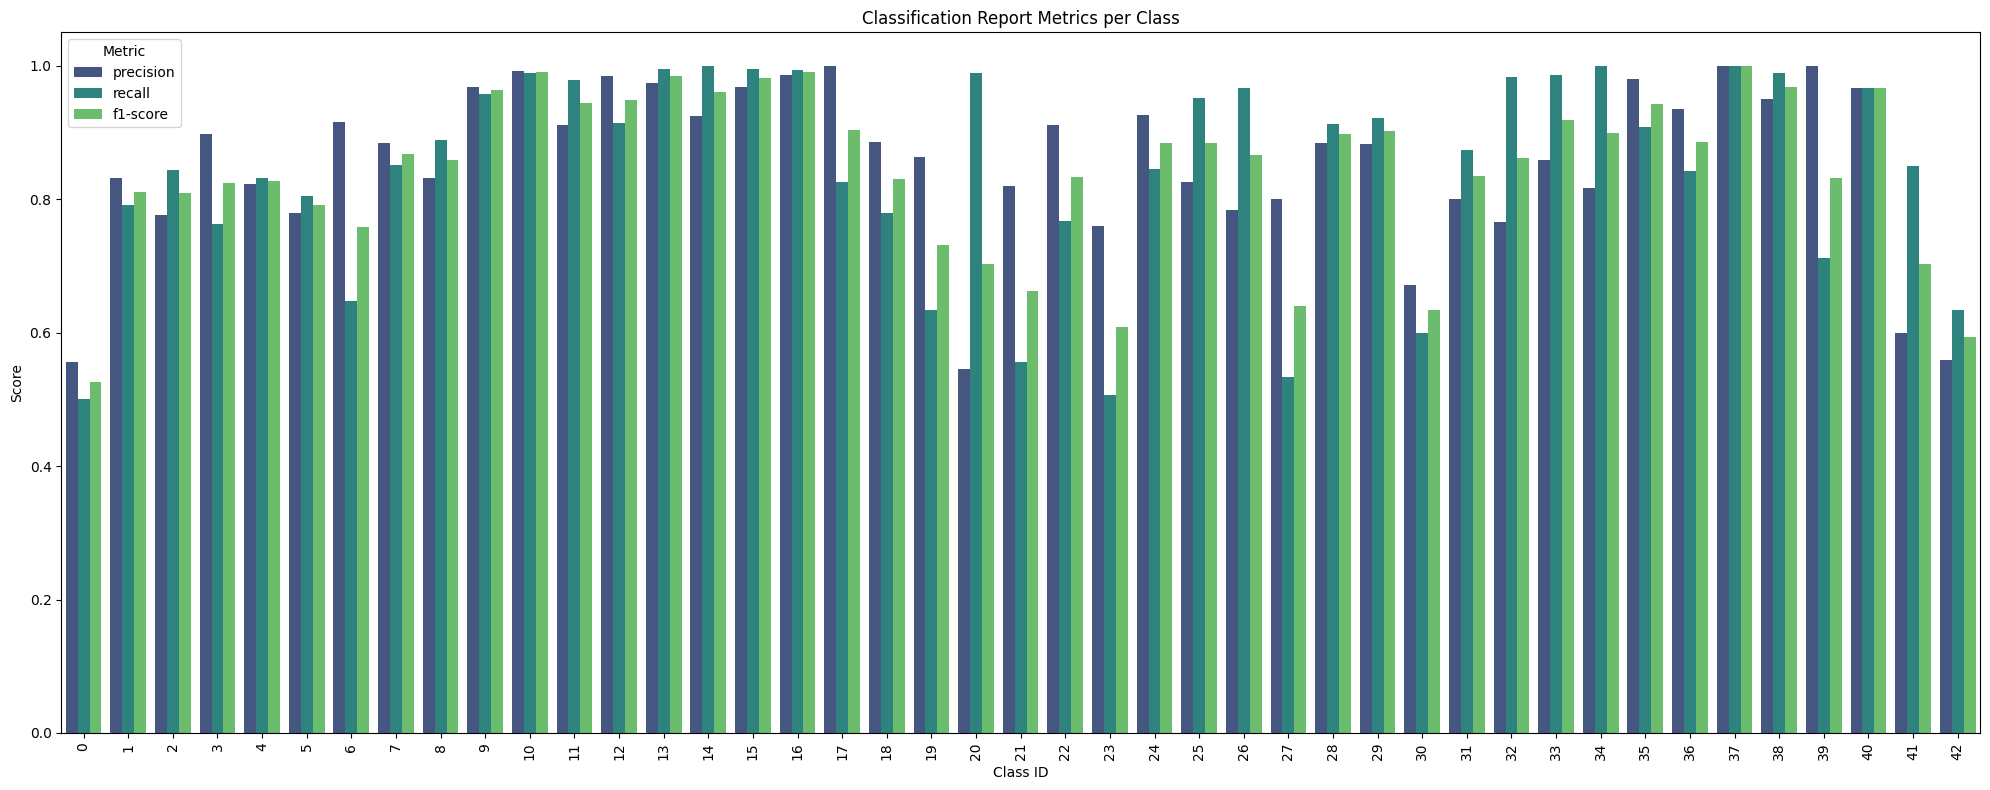

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Ensure y_test and y_pred_labels are available from previous cell execution
if 'y_test' not in locals() or 'y_pred_labels' not in locals():
    print("Warning: y_test or y_pred_labels not found. Please run the model evaluation cell first.")
else:
    report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)

    # Convert the report to a DataFrame for easier plotting
    df_report = pd.DataFrame(report).transpose()

    # Drop 'accuracy', 'macro avg', 'weighted avg' rows as they are overall metrics
    df_report = df_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # Filter to only include 'precision', 'recall', 'f1-score'
    df_plot = df_report[['precision', 'recall', 'f1-score']]

    # Reset index to make 'Class ID' a column
    df_plot = df_plot.reset_index().rename(columns={'index': 'Class ID'})

    # Melt the DataFrame for seaborn's barplot
    df_melted = df_plot.melt(id_vars='Class ID', var_name='Metric', value_name='Score')

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Class ID', y='Score', hue='Metric', data=df_melted, palette='viridis')
    plt.title('Classification Report Metrics per Class')
    plt.xlabel('Class ID')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.05) # Scores are between 0 and 1
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# GAUSSIAN 20 BLUR

In [ ]:
import keras_tuner as kt
import tensorflow as tf
import math

print("\n--- Training Final Model with Specified Hyperparameters ---")

# 1. Define a HyperParameters object and populate it with the desired values
specified_hps = kt.HyperParameters()
specified_hps.values['class_weight_multiplier'] = 2
specified_hps.values['dropout_1'] = 0.21658
specified_hps.values['dropout_2_conv'] = 0.32308
specified_hps.values['dropout_3_dense'] = 0.48679
specified_hps.values['filters_1'] = 32
specified_hps.values['filters_2'] = 64
specified_hps.values['units'] = 384
specified_hps.values['learning_rate'] = 0.00071331

# 2. Build the model using the build_tuned_model function and the specified HPs
final_model_with_hps = build_tuned_model(specified_hps)

# 3. Get the class weights for this specific set of hyperparameters
final_class_weights_for_hps = final_model_with_hps.tuned_class_weights

# 4. Prepare data generators (assuming datagen, X_train, y_train, X_val, y_val are in scope)
BATCH_SIZE = 32
train_generator_final_hps = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
steps_per_epoch_final_hps = math.ceil(len(X_train) / BATCH_SIZE)

# 5. Train the model
print("Starting training with the specified hyperparameters...")
history_specified_hps = final_model_with_hps.fit(
    train_generator_final_hps,
    epochs=50, # Train for 50 epochs as requested
    steps_per_epoch=steps_per_epoch_final_hps,
    validation_data=(X_val, y_val),
    class_weight=final_class_weights_for_hps,
    callbacks=[early_stopping, lr_scheduler], # Assuming early_stopping and lr_scheduler are in scope
    verbose=1
)

print("\n--- Training Complete with Specified Hyperparameters ---")


--- Training Final Model with Specified Hyperparameters ---
Starting training with the specified hyperparameters...
Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.0674 - f1_score: 0.0391 - loss: 6.8531 - val_accuracy: 0.2448 - val_f1_score: 0.2092 - val_loss: 2.4300 - learning_rate: 7.1331e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.1501 - f1_score: 0.1387 - loss: 4.2270 - val_accuracy: 0.2896 - val_f1_score: 0.2877 - val_loss: 2.2011 - learning_rate: 7.1331e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.2252 - f1_score: 0.2196 - loss: 3.5832 - val_accuracy: 0.4518 - val_f1_score: 0.4542 - val_loss: 1.6310 - learning_rate: 7.1331e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.2954 - f1_score: 0.3030 - loss: 3.1961 - val_accuracy: 0.5235 - val_f1_score: 0.4966 - val_loss: 1.4904 - learning_rate: 7.1331e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.3487 - f1_score

In [ ]:
from sklearn.metrics import classification_report

print("\n--- Evaluating Final Model on Test Set ---")

# Evaluate the model
loss, accuracy, f1_score_test = final_model_with_hps.evaluate(X_test, y_test, verbose=1)

print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Model Test F1-Score: {f1_score_test:.4f}")

# Optionally, generate a classification report for more detailed metrics
y_pred_probabilities = final_model_with_hps.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_labels, zero_division=0))


--- Evaluating Final Model on Test Set ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9055 - f1_score: 0.9071 - loss: 0.3823

Final Model Test Loss: 0.3946
Final Model Test Accuracy: 90.56%
Final Model Test F1-Score: 0.9075
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.46      0.70      0.55        60
           1       0.83      0.79      0.81       720
           2       0.88      0.82      0.85       750
           3       0.96      0.83      0.89       450
           4       0.96      0.91      0.94       660
           5       0.74      0.83      0.78       630
           6       0.92      0.86      0.89       150
           7       0.87      0.87      0.87       450
           8       0.77      0.90      0.83       450
           9       1.00      1.00      1.00       480
          10       0.99      0.98      0.99       660
          11       0.97      0.91    

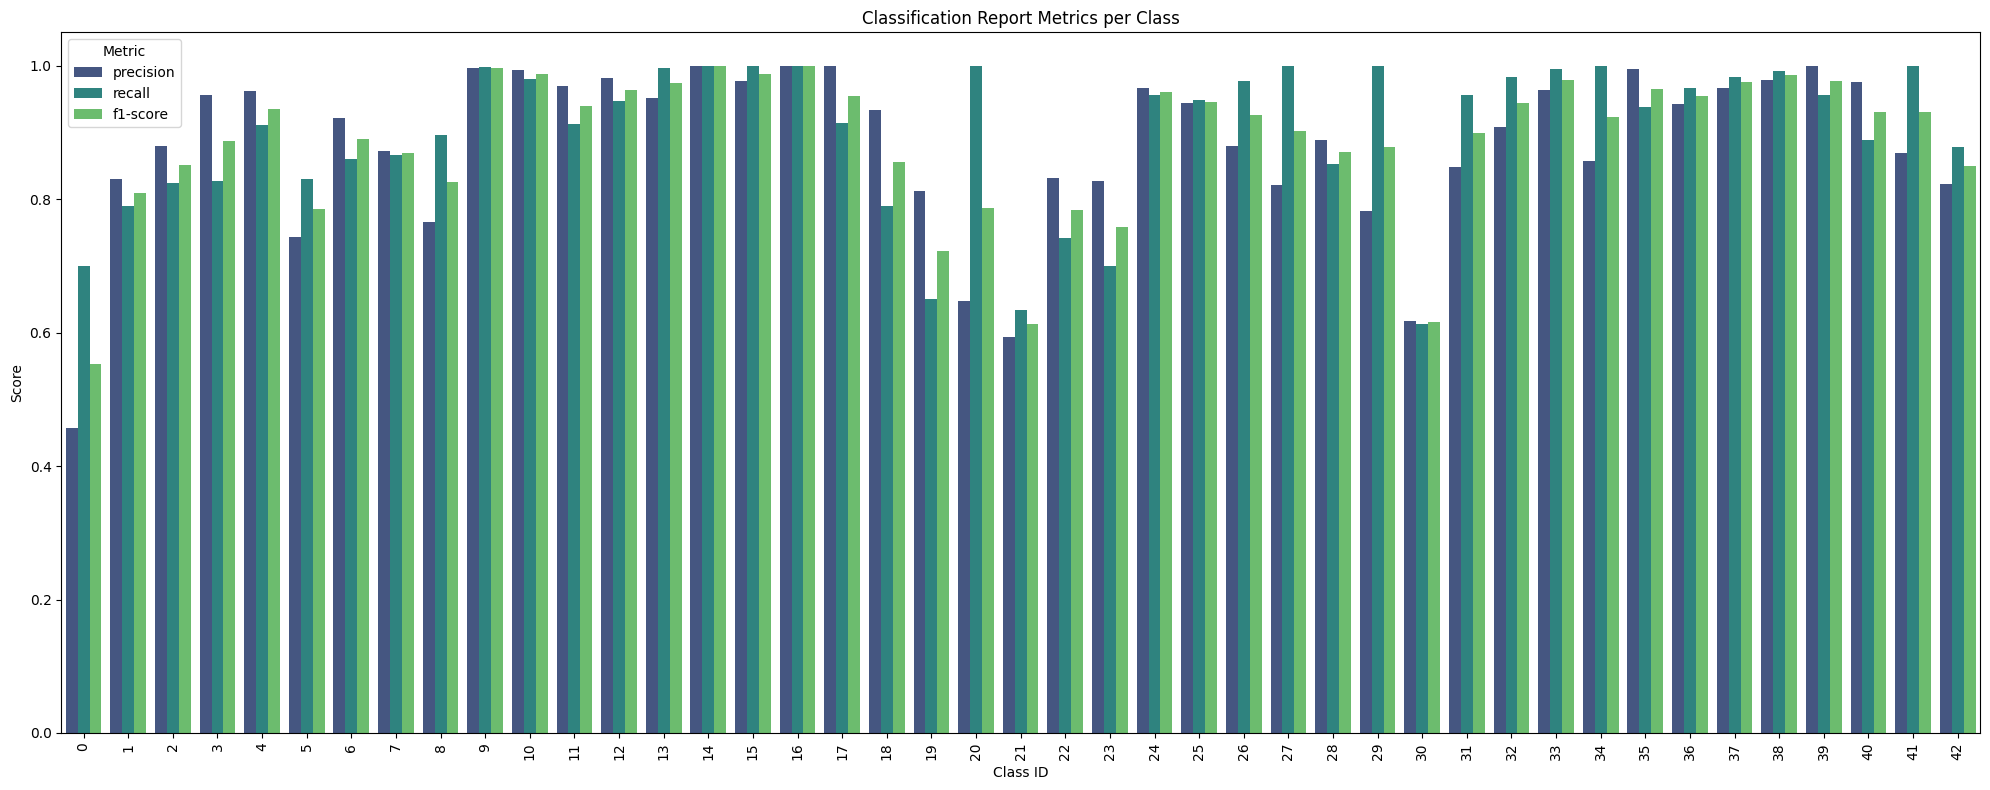

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Ensure y_test and y_pred_labels are available from previous cell execution
if 'y_test' not in locals() or 'y_pred_labels' not in locals():
    print("Warning: y_test or y_pred_labels not found. Please run the model evaluation cell first.")
else:
    report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)

    # Convert the report to a DataFrame for easier plotting
    df_report = pd.DataFrame(report).transpose()

    # Drop 'accuracy', 'macro avg', 'weighted avg' rows as they are overall metrics
    df_report = df_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # Filter to only include 'precision', 'recall', 'f1-score'
    df_plot = df_report[['precision', 'recall', 'f1-score']]

    # Reset index to make 'Class ID' a column
    df_plot = df_plot.reset_index().rename(columns={'index': 'Class ID'})

    # Melt the DataFrame for seaborn's barplot
    df_melted = df_plot.melt(id_vars='Class ID', var_name='Metric', value_name='Score')

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Class ID', y='Score', hue='Metric', data=df_melted, palette='viridis')
    plt.title('Classification Report Metrics per Class')
    plt.xlabel('Class ID')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.05) # Scores are between 0 and 1
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# AVERAGE BLUR 20

In [ ]:
import keras_tuner as kt
import tensorflow as tf
import math

print("\n--- Training Final Model with Specified Hyperparameters ---")

# 1. Define a HyperParameters object and populate it with the desired values
specified_hps = kt.HyperParameters()
specified_hps.values['class_weight_multiplier'] = 1.5
specified_hps.values['dropout_1'] = 0.12079240318451744
specified_hps.values['dropout_2_conv'] = 0.3502689191134226
specified_hps.values['dropout_3_dense'] = 0.4454621813819573
specified_hps.values['filters_1'] = 64
specified_hps.values['filters_2'] = 64
specified_hps.values['units'] = 512
specified_hps.values['learning_rate'] = 0.0001842189128502138

# 2. Build the model using the build_tuned_model function and the specified HPs
# Assuming build_tuned_model, f1_score, CLASS_WEIGHTS_DICT, NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH, CHANNELS are in scope
final_model_with_hps = build_tuned_model(specified_hps)

# 3. Get the class weights for this specific set of hyperparameters
final_class_weights_for_hps = final_model_with_hps.tuned_class_weights

# 4. Prepare data generators (assuming datagen, X_train, y_train, X_val, y_val are in scope)
BATCH_SIZE = 32
train_generator_final_hps = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
steps_per_epoch_final_hps = math.ceil(len(X_train) / BATCH_SIZE)

# 5. Train the model
print("Starting training with the specified hyperparameters...")
history_specified_hps = final_model_with_hps.fit(
    train_generator_final_hps,
    epochs=50, # Train for 50 epochs as requested
    steps_per_epoch=steps_per_epoch_final_hps,
    validation_data=(X_val, y_val),
    class_weight=final_class_weights_for_hps,
    callbacks=[early_stopping, lr_scheduler], # Assuming early_stopping and lr_scheduler are in scope
    verbose=1
)

print("\n--- Training Complete with Specified Hyperparameters ---")



--- Training Final Model with Specified Hyperparameters ---
Starting training with the specified hyperparameters...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.1427 - f1_score: 0.1053 - loss: 4.8187 - val_accuracy: 0.5542 - val_f1_score: 0.5438 - val_loss: 1.3851 - learning_rate: 1.8422e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.4203 - f1_score: 0.4032 - loss: 2.2040 - val_accuracy: 0.7549 - val_f1_score: 0.7310 - val_loss: 0.7248 - learning_rate: 1.8422e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.5772 - f1_score: 0.5737 - loss: 1.4269 - val_accuracy: 0.8420 - val_f1_score: 0.8364 - val_loss: 0.4768 - learning_rate: 1.8422e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.6695 - f1_score: 0.6692 - loss: 1.0188 - val_accuracy: 0.8780 - val_f1_score: 0.8753 - val_loss: 0.3595 - learning_rate: 1.8422e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.7269 - f1_score: 0.7347 - loss: 0.8005 - val_accuracy: 0.8914 - val_f1_score: 0.8893 - val_loss: 0.3048 - learning_rate: 1.8422e-04
Epoch 6/50


In [ ]:
from sklearn.metrics import classification_report

print("\n--- Evaluating Final Model on Test Set ---")

# Evaluate the model
loss, accuracy, f1_score_test = final_model_with_hps.evaluate(X_test, y_test, verbose=1)

print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Model Test F1-Score: {f1_score_test:.4f}")

# Optionally, generate a classification report for more detailed metrics
y_pred_probabilities = final_model_with_hps.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_labels, zero_division=0))


--- Evaluating Final Model on Test Set ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9337 - f1_score: 0.9354 - loss: 0.2840

Final Model Test Loss: 0.2850
Final Model Test Accuracy: 93.33%
Final Model Test F1-Score: 0.9348
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.63      0.78        60
           1       0.87      0.95      0.91       720
           2       0.91      0.89      0.90       750
           3       0.88      0.93      0.90       450
           4       0.97      0.92      0.95       660
           5       0.86      0.81      0.84       630
           6       0.95      0.83      0.88       150
           7       0.90      0.86      0.88       450
           8       0.80      0.89      0.84       450
           9       1.00      0.97      0.98       480
          10       1.00      0.99      1.00       660
          11       0.92      0.98   

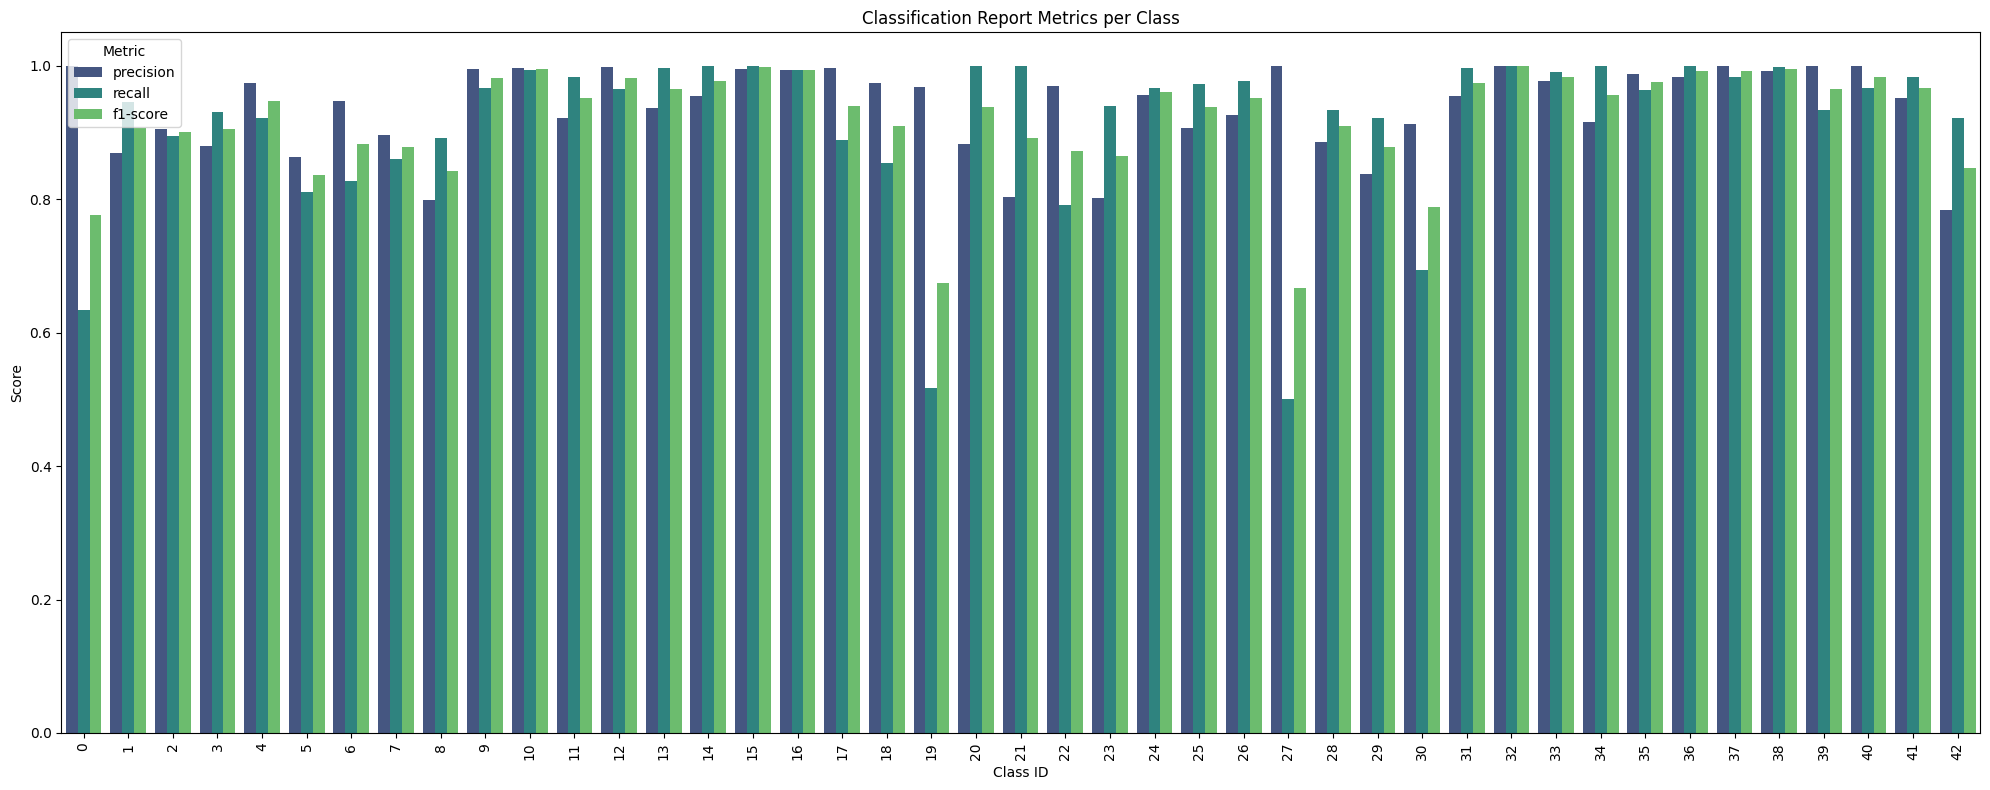

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Ensure y_test and y_pred_labels are available from previous cell execution
if 'y_test' not in locals() or 'y_pred_labels' not in locals():
    print("Warning: y_test or y_pred_labels not found. Please run the model evaluation cell first.")
else:
    report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)

    # Convert the report to a DataFrame for easier plotting
    df_report = pd.DataFrame(report).transpose()

    # Drop 'accuracy', 'macro avg', 'weighted avg' rows as they are overall metrics
    df_report = df_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # Filter to only include 'precision', 'recall', 'f1-score'
    df_plot = df_report[['precision', 'recall', 'f1-score']]

    # Reset index to make 'Class ID' a column
    df_plot = df_plot.reset_index().rename(columns={'index': 'Class ID'})

    # Melt the DataFrame for seaborn's barplot
    df_melted = df_plot.melt(id_vars='Class ID', var_name='Metric', value_name='Score')

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Class ID', y='Score', hue='Metric', data=df_melted, palette='viridis')
    plt.title('Classification Report Metrics per Class')
    plt.xlabel('Class ID')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.05) # Scores are between 0 and 1
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# AVERAGE 50 BLUR

In [ ]:
import keras_tuner as kt
import tensorflow as tf
import math

print("\n--- Training Final Model with Specified Hyperparameters ---")

# 1. Define a HyperParameters object and populate it with the desired values
specified_hps = kt.HyperParameters()
specified_hps.values['class_weight_multiplier'] = 1
specified_hps.values['dropout_1'] = 0.1352
specified_hps.values['dropout_2_conv'] = 0.35501
specified_hps.values['dropout_3_dense'] = 0.40867
specified_hps.values['filters_1'] = 64
specified_hps.values['filters_2'] = 64
specified_hps.values['units'] = 512
specified_hps.values['learning_rate'] = 0.00069038

# 2. Build the model using the build_tuned_model function and the specified HPs
# Assuming build_tuned_model, f1_score, CLASS_WEIGHTS_DICT, NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH, CHANNELS are in scope
final_model_with_hps = build_tuned_model(specified_hps)

# 3. Get the class weights for this specific set of hyperparameters
final_class_weights_for_hps = final_model_with_hps.tuned_class_weights

# 4. Prepare data generators (assuming datagen, X_train, y_train, X_val, y_val are in scope)
BATCH_SIZE = 32
train_generator_final_hps = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
steps_per_epoch_final_hps = math.ceil(len(X_train) / BATCH_SIZE)

# 5. Train the model
print("Starting training with the specified hyperparameters...")
history_specified_hps = final_model_with_hps.fit(
    train_generator_final_hps,
    epochs=50, # Train for 50 epochs as requested
    steps_per_epoch=steps_per_epoch_final_hps,
    validation_data=(X_val, y_val),
    class_weight=final_class_weights_for_hps,
    callbacks=[early_stopping, lr_scheduler], # Assuming early_stopping and lr_scheduler are in scope
    verbose=1
)

print("\n--- Training Complete with Specified Hyperparameters ---")


--- Training Final Model with Specified Hyperparameters ---
Starting training with the specified hyperparameters...
Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 53s 48ms/step - accuracy: 0.1783 - f1_score: 0.1421 - loss: 4.1874 - val_accuracy: 0.4948 - val_f1_score: 0.4623 - val_loss: 1.5720 - learning_rate: 6.9038e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.4009 - f1_score: 0.3806 - loss: 1.9085 - val_accuracy: 0.6854 - val_f1_score: 0.6473 - val_loss: 0.9205 - learning_rate: 6.9038e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.5131 - f1_score: 0.5066 - loss: 1.4842 - val_accuracy: 0.7502 - val_f1_score: 0.7301 - val_loss: 0.7565 - learning_rate: 6.9038e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.5971 - f1_score: 0.5932 - loss: 1.1649 - val_accuracy: 0.8272 - val_f1_score: 0.8140 - val_loss: 0.4945 - learning_rate: 6.9038e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.6572 - f1_score

In [ ]:
from sklearn.metrics import classification_report

print("\n--- Evaluating Final Model on Test Set ---")

# Evaluate the model
loss, accuracy, f1_score_test = final_model_with_hps.evaluate(X_test, y_test, verbose=1)

print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Model Test F1-Score: {f1_score_test:.4f}")

# Optionally, generate a classification report for more detailed metrics
y_pred_probabilities = final_model_with_hps.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_labels, zero_division=0))


--- Evaluating Final Model on Test Set ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9183 - f1_score: 0.9206 - loss: 0.4041

Final Model Test Loss: 0.4044
Final Model Test Accuracy: 91.90%
Final Model Test F1-Score: 0.9212
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.94      0.50      0.65        60
           1       0.88      0.93      0.91       720
           2       0.92      0.88      0.90       750
           3       0.92      0.91      0.92       450
           4       0.95      0.91      0.93       660
           5       0.86      0.82      0.84       630
           6       0.96      0.78      0.86       150
           7       0.82      0.88      0.85       450
           8       0.81      0.92      0.86       450
           9       0.94      0.97      0.95       480
          10       1.00      0.99      0.99       660
          11       0.96      0.98    

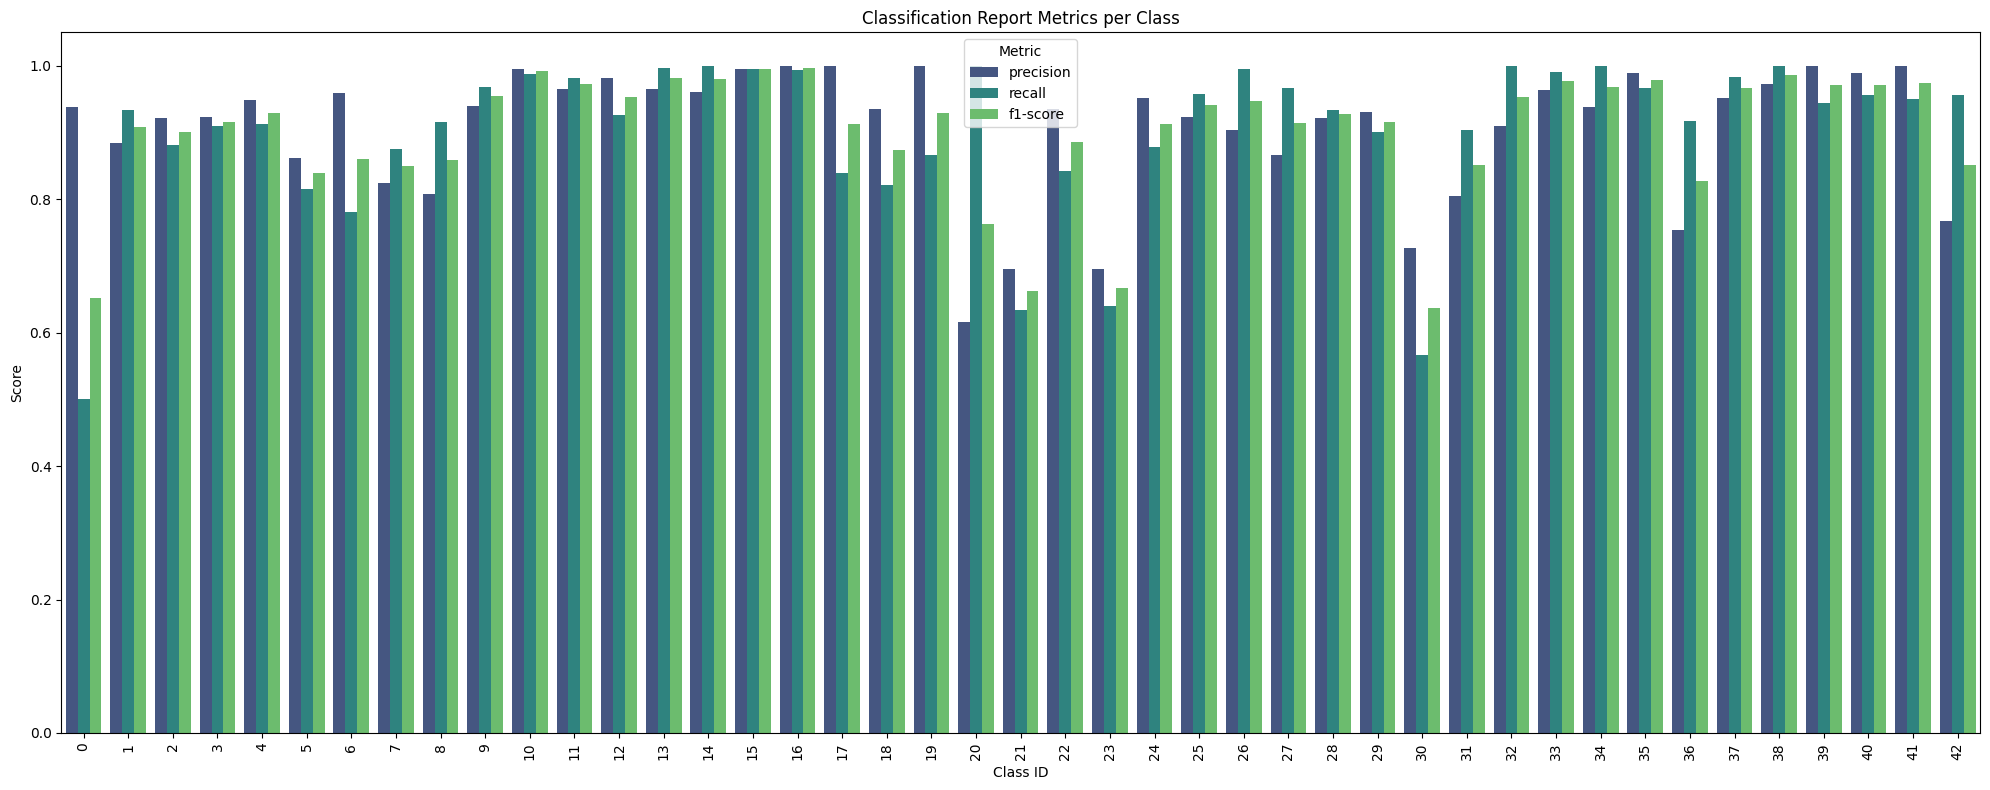

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Ensure y_test and y_pred_labels are available from previous cell execution
if 'y_test' not in locals() or 'y_pred_labels' not in locals():
    print("Warning: y_test or y_pred_labels not found. Please run the model evaluation cell first.")
else:
    report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)

    # Convert the report to a DataFrame for easier plotting
    df_report = pd.DataFrame(report).transpose()

    # Drop 'accuracy', 'macro avg', 'weighted avg' rows as they are overall metrics
    df_report = df_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # Filter to only include 'precision', 'recall', 'f1-score'
    df_plot = df_report[['precision', 'recall', 'f1-score']]

    # Reset index to make 'Class ID' a column
    df_plot = df_plot.reset_index().rename(columns={'index': 'Class ID'})

    # Melt the DataFrame for seaborn's barplot
    df_melted = df_plot.melt(id_vars='Class ID', var_name='Metric', value_name='Score')

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Class ID', y='Score', hue='Metric', data=df_melted, palette='viridis')
    plt.title('Classification Report Metrics per Class')
    plt.xlabel('Class ID')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.05) # Scores are between 0 and 1
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# AVERAGE 100 BLUR

In [ ]:
import keras_tuner as kt
import tensorflow as tf
import math

print("\n--- Training Final Model with Specified Hyperparameters ---")

# 1. Define a HyperParameters object and populate it with the desired values
specified_hps = kt.HyperParameters()
specified_hps.values['class_weight_multiplier'] = 2
specified_hps.values['dropout_1'] = 0.1758
specified_hps.values['dropout_2_conv'] = 0.23079
specified_hps.values['dropout_3_dense'] = 0.40699
specified_hps.values['filters_1'] = 32
specified_hps.values['filters_2'] = 128
specified_hps.values['units'] = 384
specified_hps.values['learning_rate'] = 0.00024123

# 2. Build the model using the build_tuned_model function and the specified HPs
# Assuming build_tuned_model, f1_score, CLASS_WEIGHTS_DICT, NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH, CHANNELS are in scope
final_model_with_hps = build_tuned_model(specified_hps)

# 3. Get the class weights for this specific set of hyperparameters
final_class_weights_for_hps = final_model_with_hps.tuned_class_weights

# 4. Prepare data generators (assuming datagen, X_train, y_train, X_val, y_val are in scope)
BATCH_SIZE = 32
train_generator_final_hps = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
steps_per_epoch_final_hps = math.ceil(len(X_train) / BATCH_SIZE)

# 5. Train the model
print("Starting training with the specified hyperparameters...")
history_specified_hps = final_model_with_hps.fit(
    train_generator_final_hps,
    epochs=50, # Train for 50 epochs as requested
    steps_per_epoch=steps_per_epoch_final_hps,
    validation_data=(X_val, y_val),
    class_weight=final_class_weights_for_hps,
    callbacks=[early_stopping, lr_scheduler], # Assuming early_stopping and lr_scheduler are in scope
    verbose=1
)

print("\n--- Training Complete with Specified Hyperparameters ---")


--- Training Final Model with Specified Hyperparameters ---
Starting training with the specified hyperparameters...
Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.0982 - f1_score: 0.0642 - loss: 6.7325 - val_accuracy: 0.3365 - val_f1_score: 0.3428 - val_loss: 3.4899 - learning_rate: 2.4123e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.2393 - f1_score: 0.2211 - loss: 3.6380 - val_accuracy: 0.4788 - val_f1_score: 0.4754 - val_loss: 2.1534 - learning_rate: 2.4123e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.3532 - f1_score: 0.3455 - loss: 2.7960 - val_accuracy: 0.5889 - val_f1_score: 0.5963 - val_loss: 1.5905 - learning_rate: 2.4123e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.4386 - f1_score: 0.4331 - loss: 2.2524 - val_accuracy: 0.6650 - val_f1_score: 0.6747 - val_loss: 1.1593 - learning_rate: 2.4123e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.4968 - f1_score

In [ ]:
from sklearn.metrics import classification_report

print("\n--- Evaluating Final Model on Test Set ---")

# Evaluate the model
loss, accuracy, f1_score_test = final_model_with_hps.evaluate(X_test, y_test, verbose=1)

print(f"\nFinal Model Test Loss: {loss:.4f}")
print(f"Final Model Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Model Test F1-Score: {f1_score_test:.4f}")

# Optionally, generate a classification report for more detailed metrics
y_pred_probabilities = final_model_with_hps.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_labels, zero_division=0))


--- Evaluating Final Model on Test Set ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8311 - f1_score: 0.8350 - loss: 1.0951

Final Model Test Loss: 1.0598
Final Model Test Accuracy: 83.10%
Final Model Test F1-Score: 0.8346
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        60
           1       0.76      0.73      0.75       720
           2       0.62      0.72      0.67       750
           3       0.82      0.73      0.77       450
           4       0.79      0.65      0.72       660
           5       0.63      0.72      0.67       630
           6       0.85      0.74      0.79       150
           7       0.65      0.86      0.74       450
           8       0.77      0.72      0.74       450
           9       0.95      0.88      0.92       480
          10       0.94      0.97      0.95       660
          11       0.91      0.98    

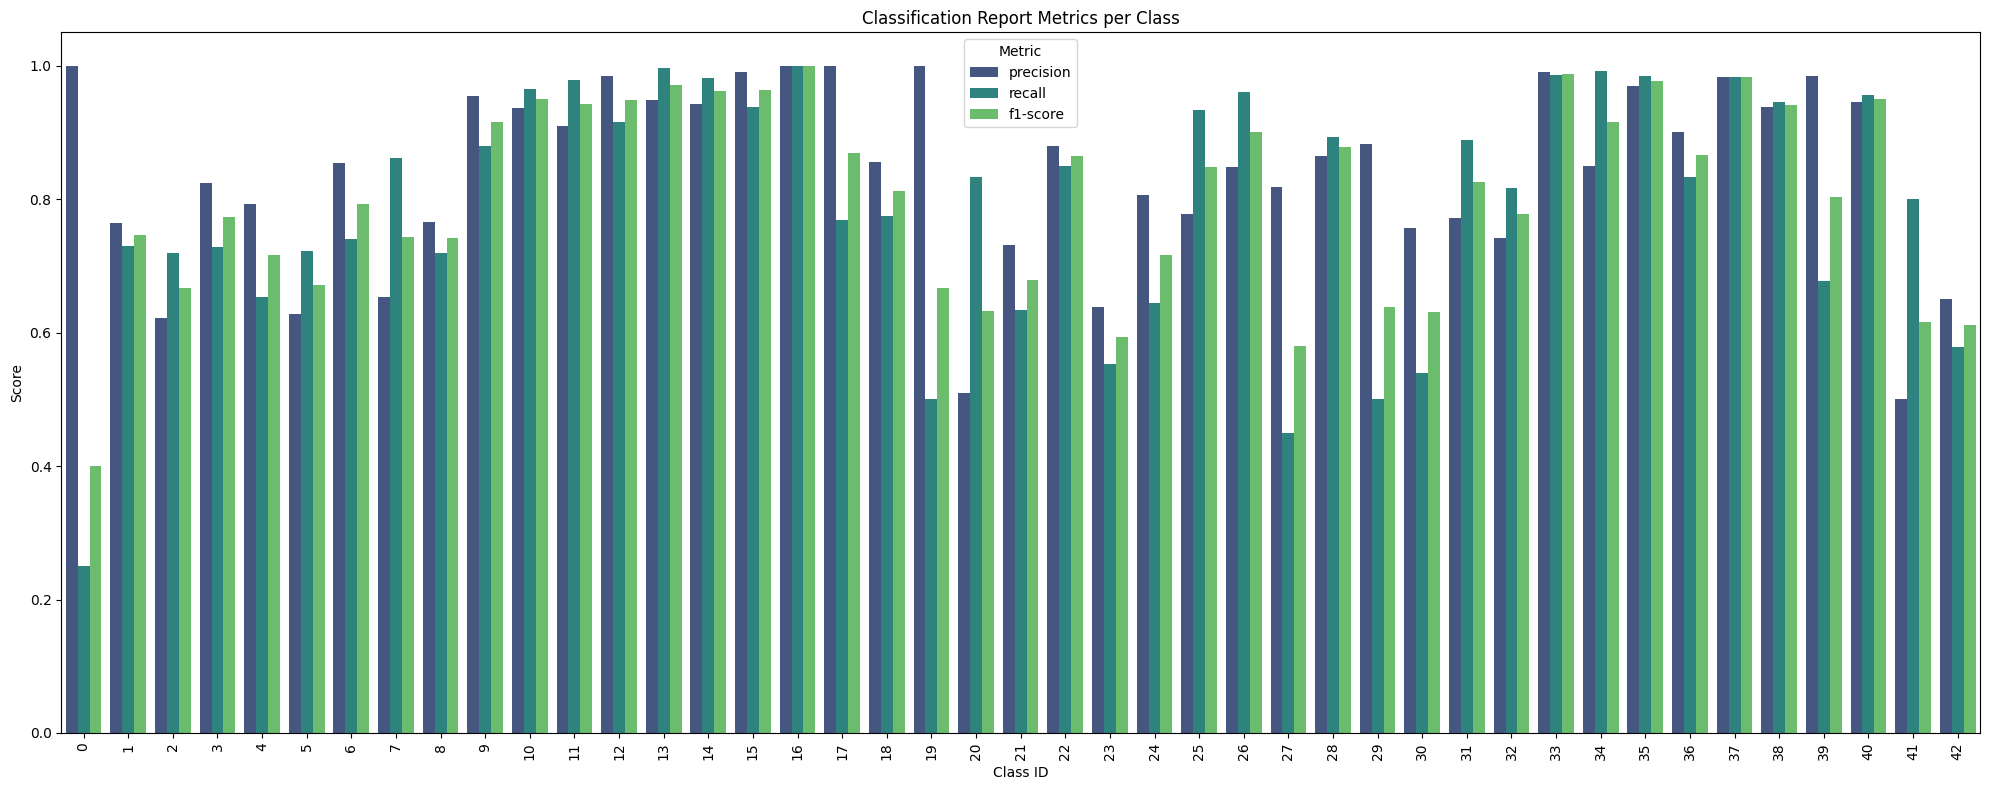

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Ensure y_test and y_pred_labels are available from previous cell execution
if 'y_test' not in locals() or 'y_pred_labels' not in locals():
    print("Warning: y_test or y_pred_labels not found. Please run the model evaluation cell first.")
else:
    report = classification_report(y_test, y_pred_labels, output_dict=True, zero_division=0)

    # Convert the report to a DataFrame for easier plotting
    df_report = pd.DataFrame(report).transpose()

    # Drop 'accuracy', 'macro avg', 'weighted avg' rows as they are overall metrics
    df_report = df_report.drop(labels=['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # Filter to only include 'precision', 'recall', 'f1-score'
    df_plot = df_report[['precision', 'recall', 'f1-score']]

    # Reset index to make 'Class ID' a column
    df_plot = df_plot.reset_index().rename(columns={'index': 'Class ID'})

    # Melt the DataFrame for seaborn's barplot
    df_melted = df_plot.melt(id_vars='Class ID', var_name='Metric', value_name='Score')

    plt.figure(figsize=(20, 8))
    sns.barplot(x='Class ID', y='Score', hue='Metric', data=df_melted, palette='viridis')
    plt.title('Classification Report Metrics per Class')
    plt.xlabel('Class ID')
    plt.ylabel('Score')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.05) # Scores are between 0 and 1
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# SAMPLE BLURRED IMAGES


--- Reviewing Saved Blur Samples ---
Displaying 5 samples from: /content/blurred_images_output/Validation_Blur_GAUSSIAN_50percent


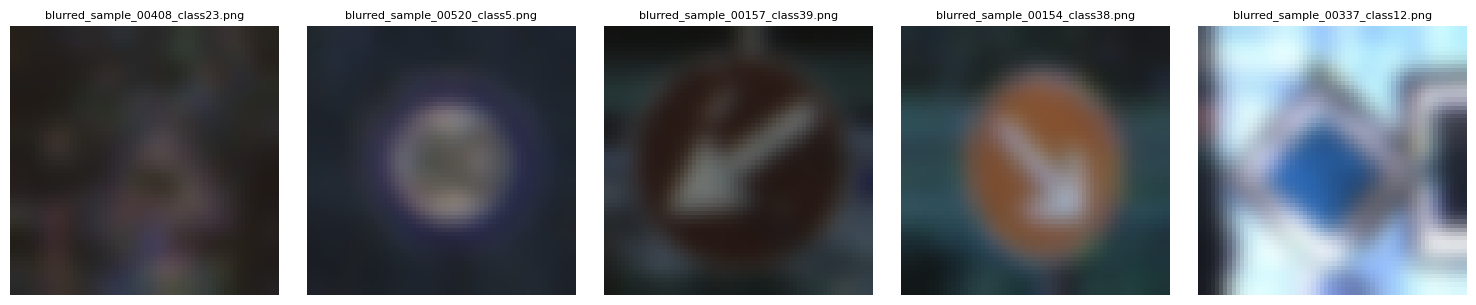


To access all saved samples, check the folder in your Colab file explorer:
/content/blurred_images_output/Validation_Blur_GAUSSIAN_50percent
You can right-click the folder and download it.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

print("\n--- Reviewing Saved Blur Samples ---")

# Find the most recently created blur folder
blur_folders = sorted(glob.glob(os.path.join(OUTPUT_DIR, '*_Blur_*')))
if blur_folders:
    latest_folder = blur_folders[-1]
    sample_files = glob.glob(os.path.join(latest_folder, '*.png'))

    if sample_files:
        print(f"Displaying 5 samples from: {latest_folder}")

        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i, ax in enumerate(axes.flat):
            if i < len(sample_files):
                img = mpimg.imread(sample_files[i])
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert back from BGR
                ax.set_title(os.path.basename(sample_files[i]), fontsize=8)
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()

        print("\nTo access all saved samples, check the folder in your Colab file explorer:")
        print(f"{latest_folder}")
        print("You can right-click the folder and download it.")
    else:
        print("No sample images found in the output directory.")
else:
    print("No blur folders found. Check your BLUR_CONFIG settings.")



--- Comparing Blur Rates on Specific Images ---


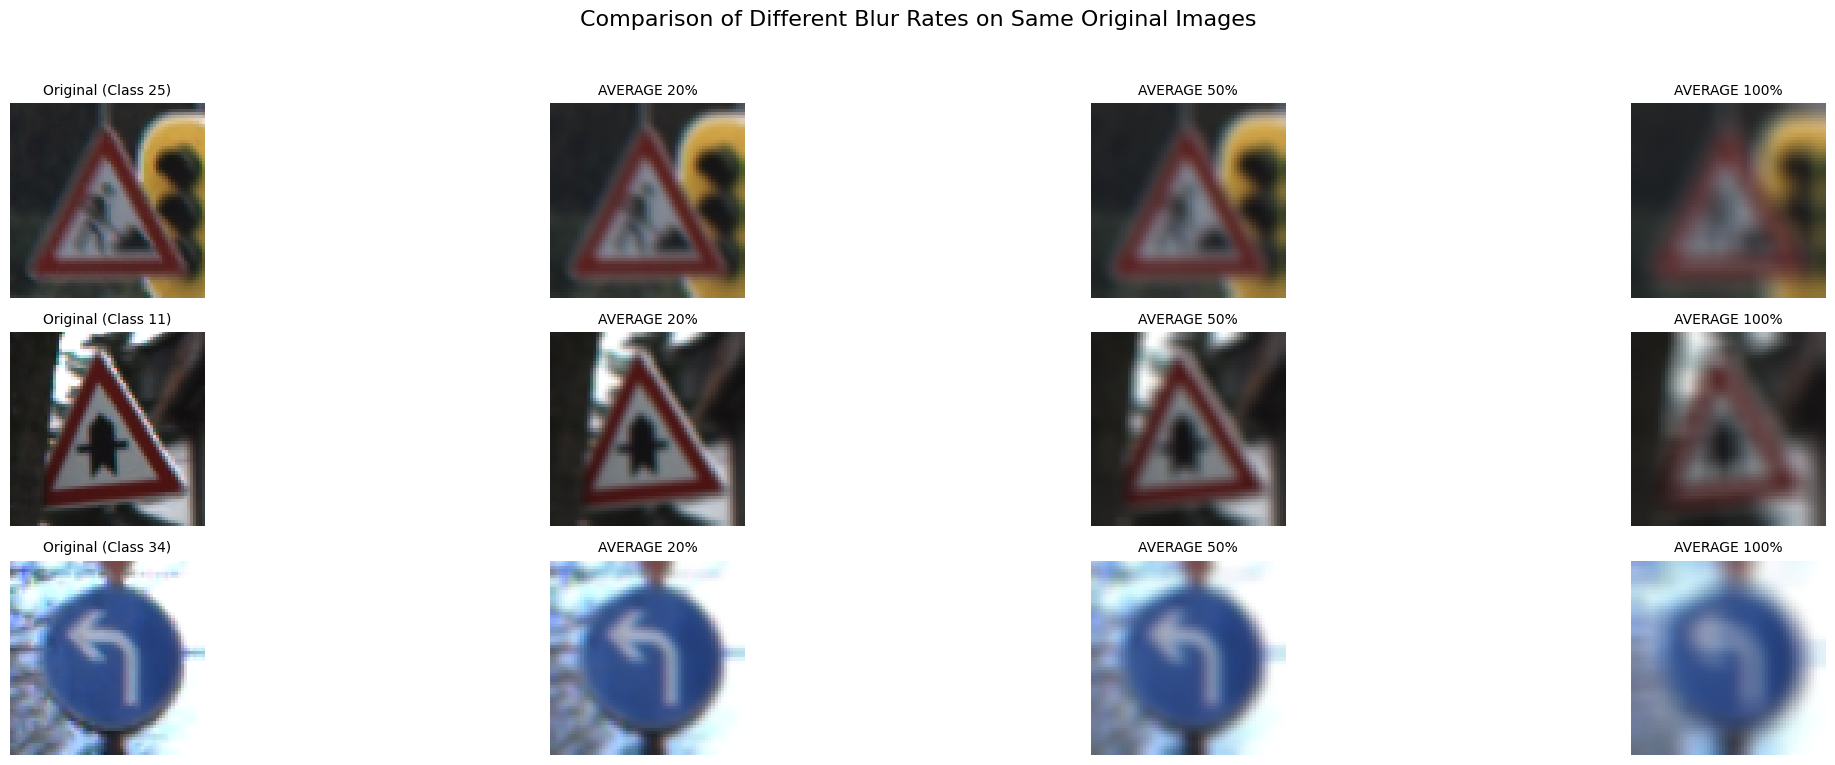

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

print("\n--- Comparing Blur Rates on Specific Images ---")

# 1. Select a few random image indices from the full original training set
# We'll use X_train_full which is the unblurred original data (before splitting and blurring)
num_comparison_images = 3
# Ensure these indices are within the bounds of X_train_full
chosen_indices = np.random.choice(len(X_train_full), num_comparison_images, replace=False)

# Get the original images. Remember X_train_full is not yet normalized (0-255)
original_comparison_images = X_train_full[chosen_indices]
original_comparison_labels = y_train_full[chosen_indices]

# Define blur intensities to compare
blur_intensities = [20, 50, 100] # You can adjust these values

# Create a figure to display the comparison
fig, axes = plt.subplots(num_comparison_images, len(blur_intensities) + 1, figsize=(15 + 3*len(blur_intensities), 8))
fig.suptitle('Comparison of Different Blur Rates on Same Original Images', fontsize=16)

# Helper function to apply blur to a single image based on BLUR_CONFIG type
def apply_single_image_blur(image, intensity_percent, blur_type):
    if intensity_percent <= 0:
        return image # No blur

    if blur_type.upper() == 'GAUSSIAN':
        sigma = (intensity_percent / 100.0) * 5.0
        blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
    elif blur_type.upper() == 'AVERAGE':
        kernel_size = int(np.ceil((intensity_percent / 100.0) * 4)) * 2 + 1
        kernel_size = max(1, kernel_size)
        blurred = cv2.blur(image, (kernel_size, kernel_size))
    else:
        blurred = image # Fallback
    return blurred

# Loop through each chosen original image
for i, original_img in enumerate(original_comparison_images):
    # Display the original image
    ax_original = axes[i, 0] if num_comparison_images > 1 else axes[0]
    ax_original.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax_original.set_title(f'Original (Class {original_comparison_labels[i]})', fontsize=10)
    ax_original.axis('off')

    # Apply and display different blur intensities
    for j, intensity in enumerate(blur_intensities):
        blurred_img = apply_single_image_blur(original_img, intensity, BLUR_CONFIG['blur_type'])

        ax_blurred = axes[i, j + 1] if num_comparison_images > 1 else axes[j + 1]
        ax_blurred.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
        ax_blurred.set_title(f'{BLUR_CONFIG["blur_type"]} {intensity}%', fontsize=10)
        ax_blurred.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()
